Step 1: Load the MNIST dataset

In [1]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch

batch_size_train = 64
batch_size_test = 1000
n_epochs = 3

def loadDataSets():
    global mnist_trainset

    mnist_trainset = datasets.MNIST(root='./data', train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))


    global train_loader
    train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

    mnist_testset = datasets.MNIST(root='./data', train=False,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

    global test_loader
    test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

loadDataSets()



Step 2: Plot a subset of the Dataset

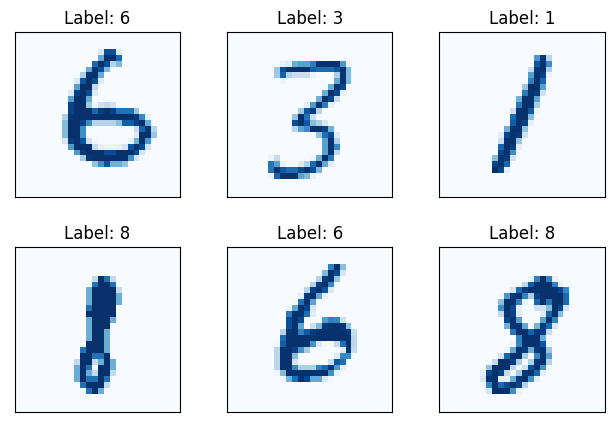

In [2]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='Blues', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


Step 3: Construct Model

In [3]:
import torch
from torch import nn

class CNN(torch.nn.Module):
    def __init__(self, initweights = False, usebias = False, hiddenunits = 128):
        self.hiddenunits = hiddenunits
        self.usebias = usebias
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias = self.usebias)

        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias = self.usebias)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear_1 = nn.Linear(7 * 7 * 32, self.hiddenunits, bias=self.usebias)
        self.linear_2 = nn.Linear(self.hiddenunits, self.hiddenunits*2, bias=self.usebias)
        self.linear_3 = nn.Linear(self.hiddenunits*2, 10, bias=self.usebias)


        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        if initweights:
            nn.init.kaiming_normal_(self.conv_1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.conv_2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in',nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.xavier_normal_(self.linear_3.weight)


    def forward(self, x):
        x = self.conv_1(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)

        x = self.linear_2(x)
        x = self.sigmoid(x)
        x = self.linear_3(x)

        out = self.softmax(x)

        return out


loss_fn = nn.CrossEntropyLoss()

def initializeModel(learning_rate, initweight = False, initbias = False, hiddenunits=128):
    global cnn
    cnn = CNN(initweight, initbias, hiddenunits)

    print(cnn)

    global loss_fn
    loss_fn = nn.CrossEntropyLoss()

    global optimizer
    optimizer = torch.optim.Adam(params=cnn.parameters(), lr=learning_rate)



Step 4: Training the Model

In [7]:
log_interval = 10
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    cnn.to(device)

    cnn.train()
    total_train_loss = 0

    for epoch in range(num_epochs):

        for itr, (image, label) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = cnn(image)
            loss = loss_fn(pred, label)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            if itr % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, itr * len(image), len(train_loader.dataset), 100. * itr / len(train_loader), loss.item()))
                train_losses.append(loss.item())
                train_counter.append((itr*64) + ((epoch-1)*len(train_loader.dataset)))
                torch.save(cnn.state_dict(), './data/model.pth')
                torch.save(optimizer.state_dict(), './data/optimizer.pth')


Step 5: Hyperparameter Tuning with GridSearchCV

In [11]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Instance of `NeuralNetClassifier` to be passed to `GridSearchCV`

def optimize():

    lr = 0.001
    epochs = 3
    device = 'cpu'



    net = NeuralNetClassifier(
        module=CNN, max_epochs=epochs,
        optimizer=torch.optim.Adam,
        train_split = None,
        criterion=loss_fn,
        lr=lr, verbose=0)

    params = {
        'lr': [0.001, 0.01, 0.005],
        'max_epochs': list(range(1, 3, 5)),
        'module__hiddenunits': [32, 64],
        'module__usebias' : [False, True],
        'module__initweights' : [False, True]
        }

    gs = GridSearchCV(
            net, params,  refit=False, scoring='accuracy', verbose=1, cv=2, error_score='raise'
    )

    counter = 0
    # Run each fit for 2 batches. So, if we have `n` fits, then it will
    # actually for `n*2` times. We have 672 fits, so total,
    # 672 * 2 = 1344 runs.
    search_batches = 2

    for i, data in enumerate(train_loader):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        outputs = gs.fit(image, labels)
        # GridSearch for `search_batches` number of times.
        if counter == search_batches:
            break

    print('SEARCH COMPLETE')
    print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))
    return gs



Step 6: Test Model

In [12]:
def test():
  cnn.eval()
  totalLoss=0
  correct=0
  total=0

  with torch.no_grad():
    for data, target in test_loader:
      networkoutput = cnn(data)

      loss= loss_fn(networkoutput,target)
      totalLoss+=loss.item()

      _, predicted = networkoutput.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()

  test_loss=totalLoss/len(test_loader)
  accu=100.*correct/total

  test_losses.append(test_loss)

  print('Testing Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))



#optimize params using GridSearchCV



Step7: Optimize with GridSearchCV

In [ ]:
best = optimize()

lr = best.best_params_['lr']
initweights = best.best_params_['module__initweights']
initbias = best.best_params_['module__initweights']
usebias = best.best_params_['module__usebias']
hiddenunits = best.best_params_['module__hiddenunits']

initializeModel(lr, initweights, initbias, hiddenunits)

train_losses = []
train_counter = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Step 8: Experiment 1

In [ ]:
initializeModel(0.001, False, False, 64)

train_losses = []
train_counter = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Step 9: Experiment 2

In [ ]:
initializeModel(0.01, True, True, 32)

train_losses = []
train_counter = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Step 10: Show Model Performance

Text(0, 0.5, 'loss')

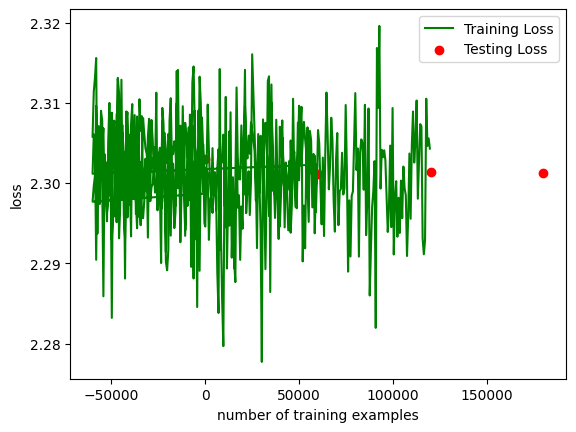

In [9]:

plt.plot(train_counter, train_losses, color='green')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.xlabel('number of training examples')
plt.ylabel('loss')




Step 11: Show prediction

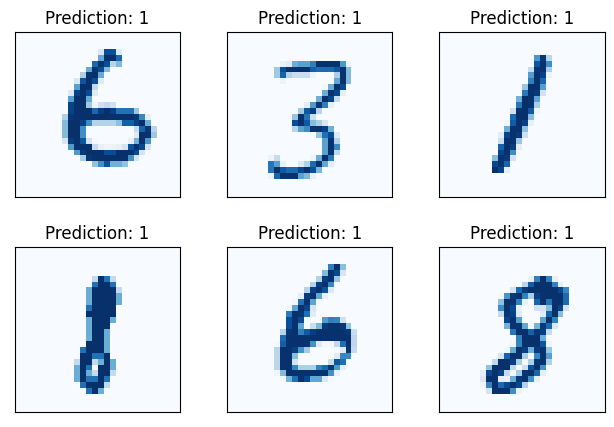

In [10]:
with torch.no_grad():
  output = cnn(example_data)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='Blues', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])